In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input, AdditiveAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mahadidn/wind-speed-forecasting/refs/heads/main/datasets/1994-2025-univariat.csv')
df.head(5)

,TANGGAL,FF_AVG
0,1994-03-01,11.0
1,1994-03-02,10.0
2,1994-03-03,9.0
3,1994-03-04,5.0
4,1994-03-05,3.0


In [3]:
# Pembagian data 70% training, 20% validasi, dan 10% testing
n = len(df)
n_train = int(n * 0.70)
n_val   = int(n * 0.20)
n_test  = n - n_train - n_val

train_df = df.iloc[:n_train].copy()
val_df   = df.iloc[n_train : n_train + n_val].copy()
test_df  = df.iloc[n_train + n_val :].copy()

print(f"Total: {n}, Train: {n_train}, Val: {n_val}, Test: {n_test}")

# cek tanggal berapa saja yang dipakai
print("Training range:", train_df['TANGGAL'].min(), "–", train_df['TANGGAL'].max())
print("Validation range:", val_df['TANGGAL'].min(), "–", val_df['TANGGAL'].max())
print("Testing range:", test_df['TANGGAL'].min(), "–", test_df['TANGGAL'].max())

Total: 11354, Train: 7947, Val: 2270, Test: 1137
Training range: 1994-03-01 – 2015-12-02
Validation range: 2015-12-03 – 2022-02-18
Testing range: 2022-02-19 – 2025-03-31


In [4]:
# fitur dan target
feature_cols = [col for col in df.columns if col != 'TANGGAL']
target_col = 'FF_AVG'

X_train = train_df[feature_cols].values
X_val = val_df[feature_cols].values
X_test = test_df[feature_cols].values

y_train = train_df[target_col].values
y_val = val_df[target_col].values
y_test = test_df[target_col].values

In [5]:
# data scaler menggunakan min max
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Save scalers
os.makedirs('models', exist_ok=True)
with open("models/X_scaler.pkl", "wb") as f:
    pickle.dump(X_scaler, f)

with open("models/y_scaler.pkl", "wb") as f:
    pickle.dump(y_scaler, f)

In [6]:
# membuat sliding window untuk multistep forecasting
def create_multistep_sequences(X, y, time_steps, forecast_horizon):
    """Create sequences for multi-step time series prediction"""
    if len(X) <= time_steps + forecast_horizon:
        raise ValueError(f"Panjang data ({len(X)}) harus lebih dari time_steps + forecast_horizon ({time_steps + forecast_horizon})")

    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        # Input sequence
        Xs.append(X[i : (i + time_steps)])
        # Multi-step output sequence
        ys.append(y[i + time_steps : i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

# Multi-step forecasting parameters
time_steps = 60
forecast_horizon = 30

# Buat multi-step sequences
X_train_seq, y_train_seq = create_multistep_sequences(X_train_scaled, y_train_scaled, time_steps, forecast_horizon)
X_val_seq, y_val_seq = create_multistep_sequences(X_val_scaled, y_val_scaled, time_steps, forecast_horizon)
X_test_seq, y_test_seq = create_multistep_sequences(X_test_scaled, y_test_scaled, time_steps, forecast_horizon)

print(f"Multi-step sequences shapes:")
print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"X_val_seq: {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")

Multi-step sequences shapes:
X_train_seq: (7858, 60, 1), y_train_seq: (7858, 30)
X_val_seq: (2181, 60, 1), y_val_seq: (2181, 30)
X_test_seq: (1048, 60, 1), y_test_seq: (1048, 30)


In [7]:
# Model BiLSTM-Attention untuk MULTIVARIAT
def create_univariat_bilstm_attention(time_steps=30, forecast_horizon=30, fitur=1, learning_rate=0.0001):
    """
    Buat model BiLSTM-Attention untuk univariat input, univariate output

    Parameters:
    - time_steps : jumlah time steps untuk input
    - forecast_horizon: jumlah steps untuk prediksi
    - fitur: jumlah input features
    - learning_rate = learning rate untuk optimizer
    """

    # Input shape: (time_steps, n_features)
    inputs = Input(shape=(time_steps, fitur))
    print(f"Model input shape: {inputs}")

    # Multiple BiLSTM layers
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(1e-3)))(inputs)
    x = Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(1e-3)))(x)

    # Attention mechanism
    context_vector = AdditiveAttention(name='attention_layer')([x, x])

    # Global average pooling untuk reduksi dimensi
    context_vector = GlobalAveragePooling1D()(context_vector)

    # Fully connected layers
    dense_1 = Dense(64, activation='relu')(context_vector)
    # Output layer
    output = Dense(forecast_horizon, activation='linear')(dense_1)

    # Create model
    model = Model(inputs=inputs, outputs=output, name='Multivariate_BiLSTM_Attention')

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [8]:
# Evaluasi Multi-step
def calculate_multistep_metrics(y_true, y_pred):
    """Hitung metrik evaluasi untuk multi-step forecasting"""

    metrics = {}
    n_steps = y_true.shape[1]

    # Keseluruhan metrik
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    metrics['keseluruhan'] = {
        'mae': mean_absolute_error(y_true_flat, y_pred_flat),
        'mape': mean_absolute_percentage_error(y_true_flat, y_pred_flat) * 100,
        'rmse': np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    }

    # metrik tiap langkah
    metrics['langkah'] = {}
    for step in range(n_steps):
        step_true = y_true[:, step]
        step_pred = y_pred[:, step]

        metrics['langkah'][f'step_{step+1}'] = {
            'mae': mean_absolute_error(step_true, step_pred),
            'mape': mean_absolute_percentage_error(step_true, step_pred) * 100,
            'rmse': np.sqrt(mean_squared_error(step_true, step_pred))
        }

    return metrics

In [9]:
models = {}
histories = {}
metrics = {}
results = []

for learning_rate in [0.0001]:
    for epochs in [200]:
        config_name = f'learning_rate_{learning_rate}_epochs_{epochs}'
        print(f"\nTraining model: {config_name}")

        # Setup direktori penyimpanan
        os.makedirs("models", exist_ok=True)
        os.makedirs("histories", exist_ok=True)
        os.makedirs("metrics", exist_ok=True)

        # Buat model
        model = create_univariat_bilstm_attention(
            time_steps=X_train_seq.shape[1],
            forecast_horizon=forecast_horizon,
            fitur=X_train_seq.shape[2],
            learning_rate=learning_rate
        )

        model.summary()

        # Training
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=epochs,
            batch_size=64,
            shuffle=False
        )

        # Simpan model ke file .keras
        model.save(f"models/{config_name}.keras")

        # Simpan history ke file .pkl
        with open(f"histories/{config_name}_history.pkl", 'wb') as f:
            pickle.dump(history, f)

        # Simpan ke dictionary (opsional, in-memory)
        models[config_name] = model
        histories[config_name] = history

print("\nSemua model, history, dan hasil evaluasi disimpan.")


Training model: learning_rate_0.0001_epochs_200
Model input shape: <KerasTensor shape=(None, 60, 1), dtype=float32, sparse=False, name=keras_tensor>


Model: "Multivariate_BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 128)   │     33,792 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 60, 64)    │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 60, 64)    │         64 │ bidirectional_1[… │
│ (AdditiveAttention) │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention_layer[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │      1,950 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,182 (317.12 KB)

 Trainable params: 81,182 (317.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.3244 - mean_absolute_error: 0.2427 - root_mean_squared_error: 0.2795 - val_loss: 0.2281 - val_mean_absolute_error: 0.1149 - val_root_mean_squared_error: 0.1453
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2186 - mean_absolute_error: 0.1175 - root_mean_squared_error: 0.1522 - val_loss: 0.1742 - val_mean_absolute_error: 0.0855 - val_root_mean_squared_error: 0.1061
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1674 - mean_absolute_error: 0.0919 - root_mean_squared_error: 0.1179 - val_loss: 0.1390 - val_mean_absolute_error: 0.0875 - val_root_mean_squared_error: 0.1077
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1334 - mean_absolute_error: 0.0909 - root_mean_squared_error: 0.1163 - val_loss: 0.1100 - val_mean_absolute_error: 0.0831 - val_root_mean_squared_error: 0.1044
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1064 - mean_absolute_error: 0.0898 - roo

In [11]:
# Evaluasi
print("Making multi-step predictions...")
y_pred_multistep_scaled = model.predict(X_test_seq, verbose=0)
print(f"Prediction shape: {y_pred_multistep_scaled.shape}")

# Langsung pakai data yang sudah normalized (0-1)
y_test_normalized = y_test_seq  # Data test yang sudah dalam bentuk normalized
y_pred_normalized = y_pred_multistep_scaled  # Prediksi yang sudah dalam bentuk normalized

# Hitung multi-step metric pada skala normalized (0-1)
multistep_metrics = calculate_multistep_metrics(y_test_normalized, y_pred_normalized)

# Display results
print("\n" + "=" * 60)
print("=== Hasil Evaluasi MULTI-STEP FORECASTING ===")
print("=" * 60)

print("\n--- Keseluruhan Performa ---")
keseluruhan = multistep_metrics['keseluruhan']
print(f'Mean Absolute Error (MAE):     {keseluruhan["mae"]:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {keseluruhan["mape"]:.2f}%')
print(f'Root Mean Square Error (RMSE): {keseluruhan["rmse"]:.4f}')

Making multi-step predictions...
Prediction shape: (1048, 30)

=== Hasil Evaluasi MULTI-STEP FORECASTING ===

--- Keseluruhan Performa ---
Mean Absolute Error (MAE):     0.0666
Mean Absolute Percentage Error (MAPE): 31.84%
Root Mean Square Error (RMSE): 0.0873


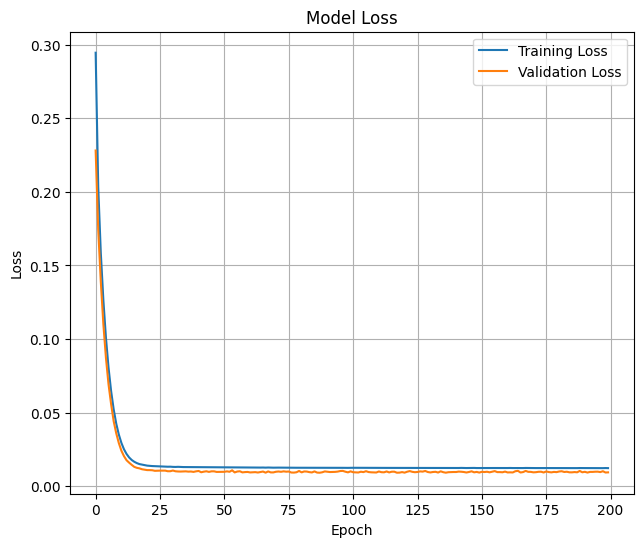

In [14]:
# Plot training history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)